In [1]:
!pip install --upgrade gdown

# Main link
# !gdown --id '1N1eVIDe9hKM5uiNRGmifBlwSDGiVXPJe' --output libriphone.zip
!gdown --id '1qzCRnywKh30mTbWUEjXuNT2isOCAPdO1' --output libriphone.zip

!unzip -q libriphone.zip
!ls libriphone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qzCRnywKh30mTbWUEjXuNT2isOCAPdO1
To: /content/libriphone.zip
100% 384M/384M [00:03<00:00, 128MB/s]
feat  test_split.txt  train_labels.txt	train_split.txt


In [18]:
!ls
!mkdir models
!ls

libriphone  libriphone.zip  sample_data
libriphone  libriphone.zip  models  sample_data


In [12]:
import os
import torch
from tqdm import tqdm

def load_feat(path):
    feat = torch.load(path)
    return feat

def shift(x, n):
    if n < 0:
        left = x[0].repeat(-n, 1)
        right = x[:n]
    elif n > 0:
        right = x[-1].repeat(n, 1)
        left = x[n:]
    else:
        return x

    return torch.cat((left, right), dim=0)

def concat_feat(x, concat_n):
    assert concat_n % 2 == 1 # n must be odd
    if concat_n < 2:
        return x
    seq_len, feature_dim = x.size(0), x.size(1)
    x = x.repeat(1, concat_n) 
    x = x.view(seq_len, concat_n, feature_dim).permute(1, 0, 2) # concat_n, seq_len, feature_dim
    mid = (concat_n // 2)
    for r_idx in range(1, mid+1):
        x[mid + r_idx, :] = shift(x[mid + r_idx], r_idx)
        x[mid - r_idx, :] = shift(x[mid - r_idx], -r_idx)

    return x.permute(1, 0, 2).view(seq_len, concat_n * feature_dim)

def preprocess_data(split, feat_dir, phone_path, concat_nframes, train_ratio=0.8, random_seed=1213):
    class_num = 41 # NOTE: pre-computed, should not need change

    if split == 'train' or split == 'val':
        mode = 'train'
    elif split == 'test':
        mode = 'test'
    else:
        raise ValueError('Invalid \'split\' argument for dataset: PhoneDataset!')

    label_dict = {}
    if mode == 'train':
        for line in open(os.path.join(phone_path, f'{mode}_labels.txt')).readlines():
            line = line.strip('\n').split(' ')
            label_dict[line[0]] = [int(p) for p in line[1:]]
        
        # split training and validation data
        usage_list = open(os.path.join(phone_path, 'train_split.txt')).readlines()
        random.seed(random_seed)
        random.shuffle(usage_list)
        train_len = int(len(usage_list) * train_ratio)
        usage_list = usage_list[:train_len] if split == 'train' else usage_list[train_len:]

    elif mode == 'test':
        usage_list = open(os.path.join(phone_path, 'test_split.txt')).readlines()

    usage_list = [line.strip('\n') for line in usage_list]
    print('[Dataset] - # phone classes: ' + str(class_num) + ', number of utterances for ' + split + ': ' + str(len(usage_list)))

    max_len = 3000000
    X = torch.empty(max_len, 39 * concat_nframes)
    if mode == 'train':
        y = torch.empty(max_len, dtype=torch.long)

    idx = 0
    for i, fname in tqdm(enumerate(usage_list)):
        feat = load_feat(os.path.join(feat_dir, mode, f'{fname}.pt'))
        cur_len = len(feat)
        feat = concat_feat(feat, concat_nframes)
        if mode == 'train':
          label = torch.LongTensor(label_dict[fname])

        X[idx: idx + cur_len, :] = feat
        if mode == 'train':
          y[idx: idx + cur_len] = label

        idx += cur_len

    X = X[:idx, :]
    if mode == 'train':
      y = y[:idx]

    print(f'[INFO] {split} set')
    print(X.shape)
    if mode == 'train':
      print(y.shape)
      return X, y
    else:
      return X

In [13]:
import numpy as np
import torch
import random

def same_seeds(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [14]:
# data prarameters
# TODO: change the value of "concat_nframes" for medium baseline
concat_nframes = 3   # the number of frames to concat with, n must be odd (total 2k+1 = n frames)
train_ratio = 0.75   # the ratio of data used for training, the rest will be used for validation

# training parameters
seed = 1213          # random seed

In [23]:
# Classes for dataset, network
# and several fuctions for data processing and trainnig

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np

# support gpu or not
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'


# split data into training data and validation data
def split_data(data, label):
    VAL_RATIO = 0.2

    percent = int(data.shape[0] * (1 - VAL_RATIO))
    train_data, train_label, val_data, val_label = data[:percent], label[:percent], data[percent:], label[percent:]
    print('Size of training set: {}'.format(train_data.shape))
    print('Size of validation set: {}'.format(val_data.shape))
    return train_data, train_label, val_data, val_label


# a custom Dataset, load data from .npy files
class VoiceDataset(Dataset):
    def __init__(self, data_train, data_label=None):
        super().__init__()
        self.data_train = data_train  # data for training
        if data_label is not None:
            self.data_label = torch.LongTensor(data_label)  # label for data used for training
        else:
            self.data_label = None

    def __getitem__(self, index):
        if self.data_label is not None:
            return self.data_train[index], self.data_label[index]  # return a element in dataset according to index
        else:
            return self.data_train[index]

    def __len__(self):
        return len(self.data_train)  # return the length of this dataset


class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super(NeuralNet, self).__init__()
        # define the network
        self.net = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, 512),
            nn.Sigmoid(),
            nn.Linear(512, 128),
            nn.Sigmoid(),
            nn.Linear(128, output_size),
        )

    def forward(self, input):
        # return the output of network
        return self.net(input)
    
    def cal_loss(self, pred, target):
        self.criterion = nn.CrossEntropyLoss()  # set loss function to Cross Entropy
        return self.criterion(pred, target)


# this function includes everything for training
def train(tr_set, dv_set, model, config, device):
    num_epochs = config['num_epochs']  # number of epochs

    # set the optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])
    
    # init parameters for epochs
    max_acc = 0.  # set the initial value for min_mse (higher than the mse after first epoch)
    loss_record = {'train': [], 'val': []}
    acc_record = {'train': [], 'val': []}
    
    # epochs for trianing
    for epoch in range(num_epochs):
        train_acc = 0
        train_loss = 0

        model.train()  # set model to trian mode
        for i, (data, label) in enumerate(tr_set):
            optimizer.zero_grad()  # set gradient to zero before calculate
            data, label = data.to(device), label.to(device)  # move data to device
            pred = model(data)  # compute the predict from data
            loss = model.cal_loss(pred, label)  # compute the mse loss
            _, train_pred = torch.max(pred, 1) # get the index of the class with the highest probability
            loss.backward()  # get the gradient
            optimizer.step()  # updata parameters in model

            train_loss += loss.item()
            train_acc += (train_pred.cpu() == label.cpu()).sum().item()

            # get loss as a tensor in cpu (item() cannot access tensor in cuda) 
            # without gradient computing requirement and trun it to a variant
            loss_record['train'].append(loss.detach().cpu().item())

            # print training status every 100 optimisations
            if (i+1) % 500 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(tr_set), loss.item()))

        # After each epoch, test your model on the validation (development) set.
        val_acc, val_loss = val(dv_set, model, device)

        train_acc = train_acc/len(tr_set.dataset)
        train_loss = train_loss/len(tr_set)

        acc_record['train'].append(train_acc)

        print('[{:03d}/{:03d}] Train ACC: {:3.6f} Loss: {:3.6f} | Val ACC: {:3.6f} loss: {:3.6f}'.format(epoch+1, num_epochs, train_acc, train_loss, val_acc, val_loss))

        if val_acc > max_acc:
            # Save model if your model improved
            max_acc = val_acc
            print('Saving model (epoch = {:4d}, acc = {:.4f})'
                .format(epoch + 1, max_acc))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        loss_record['val'].append(val_loss)
        acc_record['val'].append(val_acc)

        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break
    
    print('Finished training after {} epochs'.format(epoch+1))
    return acc_record, loss_record, max_acc


# fuction to compute mse in validation
def val(dv_set, model, device):
    model.eval()  # set model to evalutation mode
    total_loss = 0
    val_acc = 0
    for x, y in dv_set:  # iterate through the dataloader
        x, y = x.to(device), y.to(device)  # move data to device (cpu/cuda)
        with torch.no_grad():  # disable gradient calculation
            pred = model(x)  # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss

        total_loss += mse_loss.detach().cpu().item()  # accumulate loss

        _, val_pred = torch.max(pred, 1)
        val_acc += (val_pred.cpu() == y.cpu()).sum().item() # get the index of the class with the highest probability

    return val_acc/len(dv_set.dataset), total_loss / len(dv_set)


# function for model test
def test(tt_set, model, device):
    model.eval()  # set model to evalutation mode
    preds = []

    for data in tt_set:
        data = data.to(device)
        # we don't need compute gradient when testing
        with torch.no_grad():
            pred = model(data)
            _, test_pred = torch.max(pred, 1) # get the index of the class with the highest probability
            # dataloader process the dataset as batch
            for y in test_pred.cpu().numpy():
                preds.append(y)
    return preds


In [28]:
from torch.utils.data import DataLoader
import gc

same_seeds(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')

# preprocess data
train_X, train_y = preprocess_data(split='train', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=concat_nframes, train_ratio=train_ratio, random_seed=seed)
val_X, val_y = preprocess_data(split='val', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=concat_nframes, train_ratio=train_ratio, random_seed=seed)

DEVICE: cuda
[Dataset] - # phone classes: 41, number of utterances for train: 2571


2571it [00:01, 1376.93it/s]


[INFO] train set
torch.Size([1588590, 117])
torch.Size([1588590])
[Dataset] - # phone classes: 41, number of utterances for val: 858


858it [00:00, 1169.82it/s]

[INFO] val set
torch.Size([528204, 117])
torch.Size([528204])


In [29]:
!ls

libriphone  libriphone.zip  models  sample_data


In [30]:
# train the network for voice frame classification

from torch.utils.data import DataLoader
import numpy as np
import gc

# parameters for training
config = {
    'num_epochs': 100,
    'batch_size': 512,
    'optimizer': 'Adam',  # optimizer algorithm
    'optim_hparas': {
        'lr': 0.0001  # learning rate
    },
    'save_path': 'models/model.pth',
    'early_stop': 20
}

train_set = VoiceDataset(train_X, train_y)  # dataset for training
train_loader = DataLoader(dataset=train_set, batch_size=config['batch_size'], shuffle=True)

val_set = VoiceDataset(val_X, val_y)
val_loader = DataLoader(dataset=val_set, batch_size=config['batch_size'], shuffle=False)

# delete the data loaded to save space
del train_X, train_y, val_X, val_y
gc.collect()

model = NeuralNet(39 * concat_nframes, 41).to(device)  # create network

acc_record, loss_record, max_acc = train(train_loader, val_loader, model, config, device)

Epoch [1/100], Step [500/3103], Loss: 2.7834
Epoch [1/100], Step [1000/3103], Loss: 2.4466
Epoch [1/100], Step [1500/3103], Loss: 2.2453
Epoch [1/100], Step [2000/3103], Loss: 2.1414
Epoch [1/100], Step [2500/3103], Loss: 2.0637
Epoch [1/100], Step [3000/3103], Loss: 2.1165
[001/100] Train ACC: 0.349360 Loss: 2.391172 | Val ACC: 0.420991 loss: 2.038637
Saving model (epoch =    1, acc = 0.4210)
Epoch [2/100], Step [500/3103], Loss: 2.0385
Epoch [2/100], Step [1000/3103], Loss: 2.0893
Epoch [2/100], Step [1500/3103], Loss: 1.9131
Epoch [2/100], Step [2000/3103], Loss: 1.9462
Epoch [2/100], Step [2500/3103], Loss: 2.0184
Epoch [2/100], Step [3000/3103], Loss: 2.0198
[002/100] Train ACC: 0.440539 Loss: 1.961387 | Val ACC: 0.449080 loss: 1.919846
Saving model (epoch =    2, acc = 0.4491)
Epoch [3/100], Step [500/3103], Loss: 1.8348
Epoch [3/100], Step [1000/3103], Loss: 1.8831
Epoch [3/100], Step [1500/3103], Loss: 1.8166
Epoch [3/100], Step [2000/3103], Loss: 1.8725
Epoch [3/100], Step [25

In [31]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['val'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['val'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

0.5592593013305466


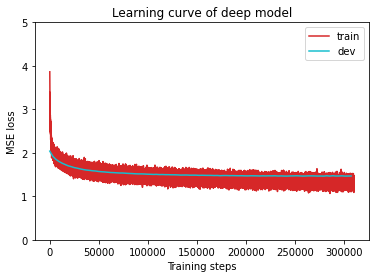

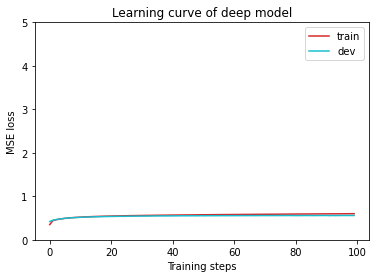

In [32]:
print(max_acc)
plot_learning_curve(loss_record, title='deep model')
plot_learning_curve(acc_record, title='deep model')

In [35]:
test_X = preprocess_data(split='test', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=concat_nframes)
test_set = VoiceDataset(test_X, None)

test_loader = DataLoader(dataset=test_set, batch_size=config['batch_size'], shuffle=False)

predicts = test(test_loader, model, device)

[Dataset] - # phone classes: 41, number of utterances for test: 857


857it [00:00, 1494.81it/s]


[INFO] test set
torch.Size([527364, 117])


In [36]:
with open('prediction.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(predicts):
        f.write('{},{}\n'.format(i, y))

In [38]:
from google.colab import files
files.download('prediction.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>